In [6]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [21]:
from torch import nn
class NN(nn.Module):

    def __init__(self, input_dim=1,  weight_dim_list=[20,20,20]):
        super(NN, self).__init__()

        self.weight_dim_list = [input_dim] + weight_dim_list
        self.layers = [None for i in weight_dim_list]

        for i in range(len(weight_dim_list)):
            setattr(
                self,
                "f" + str(i),
                nn.Linear(
                    self.weight_dim_list[i], self.weight_dim_list[i + 1],
                    bias=True
                )
            )
            self.layers[i]  = getattr(self, "f" + str(i))

            torch.nn.init.xavier_uniform(self.layers[i].weight)
    
    def get_var(self , other=None):
        return torch.tensor([[0]]).double()

    def forward(self, x, var=None):
        functerino = torch.relu
        x_ = x.clone()
        for i_, layer in enumerate(self.layers[:-1]):
            try:
                x = functerino(layer(x))
            except:
                print(x.shape, i_, x_.shape)
                import pdb; pdb.set_trace()
                raise
        try:
            return (self.layers[-1](x))
        except:
            import pdb; pdb.set_trace()
            raise


In [22]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [23]:
def divergence(outputs, inputs):
    grads_ = torch.autograd.grad(
            outputs, inputs, torch.ones_like(outputs),
            retain_graph=True, create_graph=True
     )[0]
    return grads_[:,:,:-1].sum(dim=2)

In [24]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, weight_decay = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD, lrs = None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0.requires_grad_()
            self.X_1 = X_1.requires_grad_()

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size, weight_decay=weight_decay
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size, weight_decay=weight_decay
            )
            
            m = 0.1
            lr_lambda = lambda epoch : 1.0 / (1.0 + lrs * epoch)


            self.lrs_f  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_f, lr_lambda, last_epoch=-1)
            self.lrs_b  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_b, lr_lambda, last_epoch=-1)

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
#         if not forwards :
#             Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
            div = divergence(b_minus, Xt)
        else:
            b_minus  = self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt) * self.first_iter_fac 
            div = -divergence(b_plus, Xt) * self.first_iter_fac 

            
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(dim=(1,2))  - (div.sum(dim=(1)) *  self.dt )
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)

        if not self.burn_in:
#             xx = torch.linspace(-30, 30 , 1000).reshape(-1,1).double().cuda()
#             yy = self.log_prob( xx, batch_terminal_empirical, H)  
#             plt.plot(
#                 xx.detach().cpu().numpy(),
#                 np.exp(yy.detach().cpu().numpy())
#             )
#             plt.show()
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)

        J = torch.mean(main_term +  cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                    self.lrs_b.step()
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
                    self.lrs_f.step()
  
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = self.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = self.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

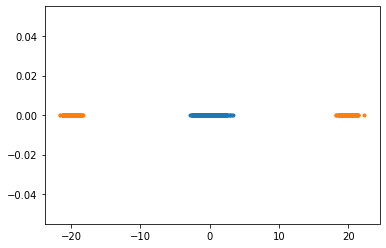

In [25]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)
n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -20
# X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [35]:


torch.cuda.manual_seed_all(10)
torch.manual_seed(10)

c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size=1e-2, weights=[100,100], rng = None,
    optimizer=torch.optim.Adagrad, lrs = 0.05, weight_decay=0
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


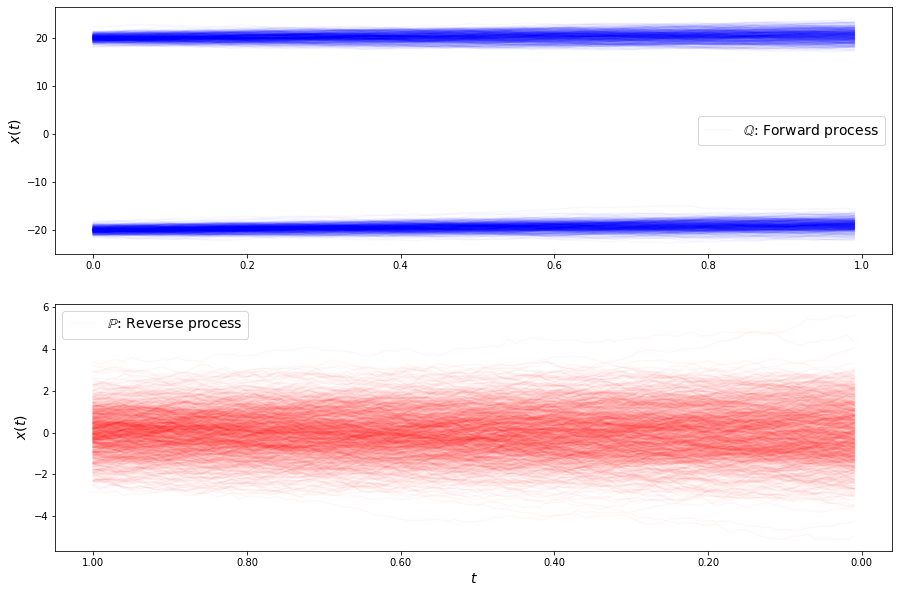

loss b 702.1191109849022
loss b 387.33392796912887
loss b 206.21270394107367
loss b 108.46578199131808
loss b 80.9055647339276
loss b 54.078949149770345
loss b 38.989303542473536
loss b 45.840296797721834
loss b 57.09093455356703
loss b 70.5499330436227
loss b 68.91830262448032
loss b 71.44970855291082
loss b 65.0294399558306
loss b 61.967313936394106
loss b 60.20657523129986
loss b 54.80898431496741
loss b 50.837109568632364
loss b 45.93096543919885
loss b 42.57932725381504
loss b 40.288740198525126
loss b 39.327097688992914
loss b 35.29610493187308
loss b 32.486343023631164
loss b 36.67114133015123
loss b 44.14368036919156
loss b 30.875248871764708
loss b 33.87173991464731
loss b 40.524922413687754
loss b 29.14745905253747
loss b 28.763298265868738
loss f 361.2537974160902
loss f 130.50125384634563
loss f 55.88117466112611
loss f 26.19033033052437
loss f 14.092150427243011
loss f 10.553940920223424
loss f 11.624850860241535
loss f 15.360080023181668
loss f 19.769641934695834
loss f 2

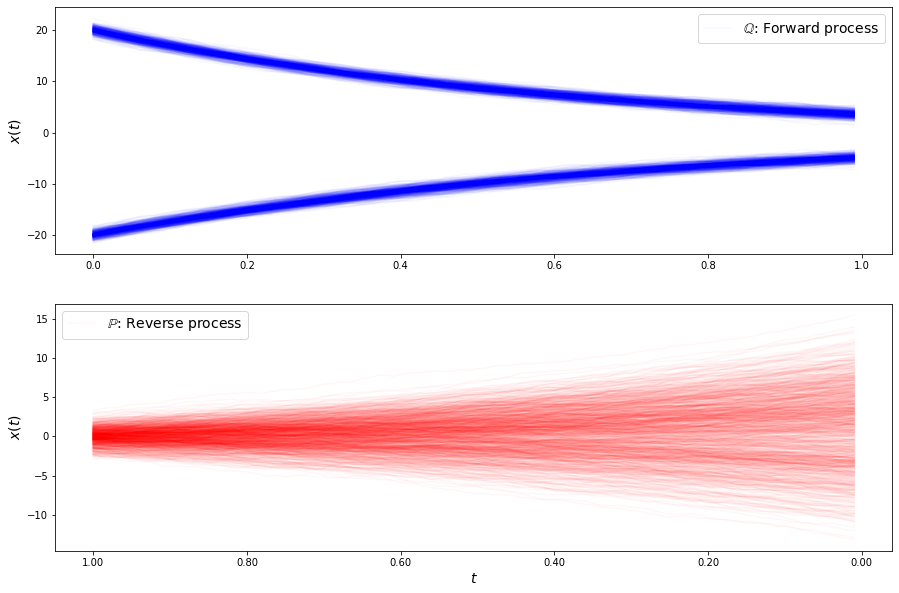

loss b 31.13061831763893
loss b 24.66388120808727
loss b 17.19578964306888
loss b 17.97870727358631
loss b 30.046891442988983
loss b 27.947950766022892
loss b 16.309891210734733
loss b 17.272552873468413
loss b 14.682897627186748
loss b 10.143028386905824
loss b 7.429597710433684
loss b 14.99762635115019
loss b 12.300358683137766
loss b 7.171990314357953
loss b 5.733688555986398
loss b 8.719160672725815
loss b 13.342615636732937
loss b 6.1602931167557005
loss b 9.583442892818177
loss b 6.895687058714211
loss b 6.564922008688359
loss b 8.663925137673937
loss b 8.070417232411394
loss b 7.120366468226714
loss b 7.011108097396328
loss b 7.052392764053338
loss b 7.507750401431977
loss b 8.245180412624107
loss b 7.976612695902617
loss b 8.0473685755171
loss f 26.00004604045502
loss f 26.863393208067357
loss f 27.18536841428373
loss f 27.106313939018854
loss f 27.385753814229627
loss f 26.072824673056186
loss f 24.94690623357158
loss f 24.337036282510475
loss f 22.715619316593838
loss f 21.20

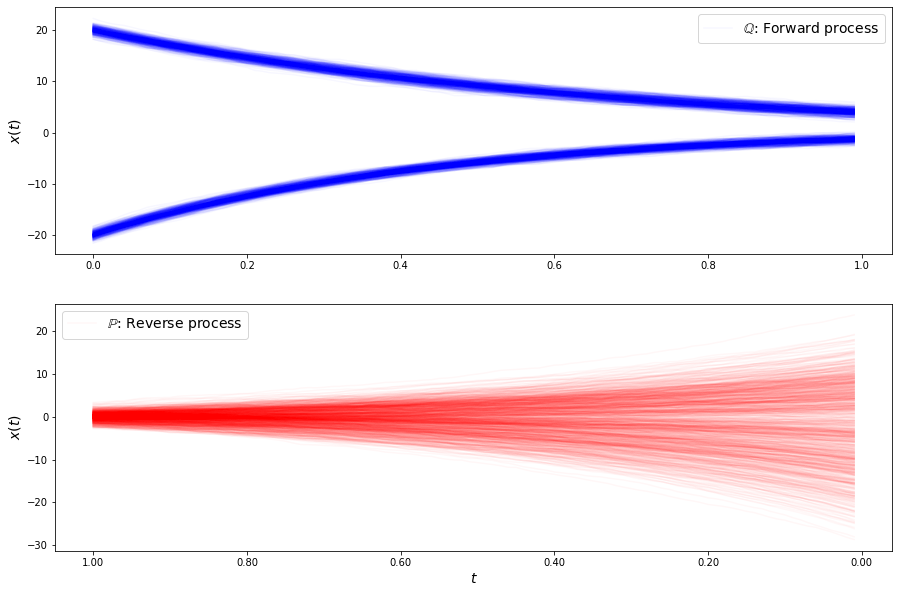

loss b 81.87285482542862
loss b 79.85357573256128
loss b 78.04379326313918
loss b 77.129573474448
loss b 75.90337445997899
loss b 74.5289269944243
loss b 73.68360981105312
loss b 71.68718612412268
loss b 70.12314471567394
loss b 69.05817966617317
loss b 67.75242470984631
loss b 67.53355096484071
loss b 65.88451010192915
loss b 63.83482727349589
loss b 62.56955804754909
loss b 62.82095050457744
loss b 61.314626319709724
loss b 60.70286915534789
loss b 60.23889403420863
loss b 59.3817080753239
loss b 59.162766589474764
loss b 58.2968939987801
loss b 57.138275457976015
loss b 57.19564385162082
loss b 56.46390038524874
loss b 56.38268484167458
loss b 56.37777056679178
loss b 55.64815006717187
loss b 54.89322389556703
loss b 54.53422596456853
loss f 24.126428385063242
loss f 24.79134134769188
loss f 25.33773361511385
loss f 26.185079144852526
loss f 26.705960768131977
loss f 27.1775522722431
loss f 27.74636214632146
loss f 28.257562655016102
loss f 28.67693864546997
loss f 28.96989181151027

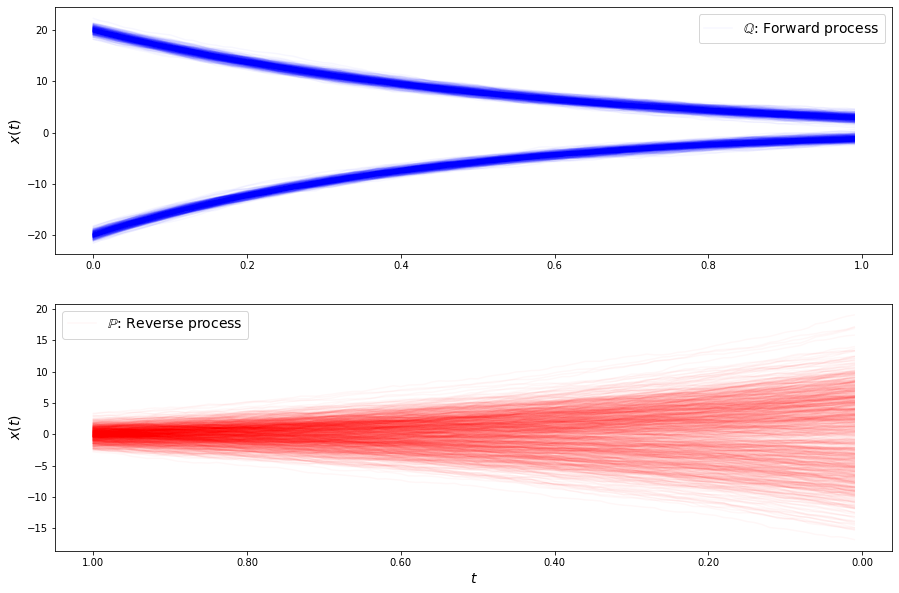

loss b 39.06696392475393
loss b 38.59638232251647
loss b 38.8974333248216
loss b 38.93760478766502
loss b 39.20384440950715
loss b 39.381259009739814
loss b 38.80661496806358
loss b 39.486128934677986
loss b 38.44858135294781
loss b 38.79571539877902
loss b 39.060233493357764
loss b 38.678797892770234
loss b 38.814099504698284
loss b 39.34882850358645
loss b 39.47417444854897
loss b 39.13955716119113
loss b 38.95259308987548
loss b 38.77865901091043
loss b 39.13655925820513
loss b 39.4117165916697
loss b 39.118005879141435
loss b 38.782106875158526
loss b 38.57602419858451
loss b 38.90578378860694
loss b 38.65811815847824
loss b 38.84159431411405
loss b 38.46745607116002
loss b 38.51367752620588
loss b 37.66062090209879
loss b 38.083957006055186
loss f 24.369991454478008
loss f 23.62304051869374
loss f 22.86646301962381
loss f 22.305562401127833
loss f 21.485494052847315
loss f 20.910860240100337
loss f 20.171693384136756
loss f 19.57621024575059
loss f 18.90364121397477
loss f 18.3850

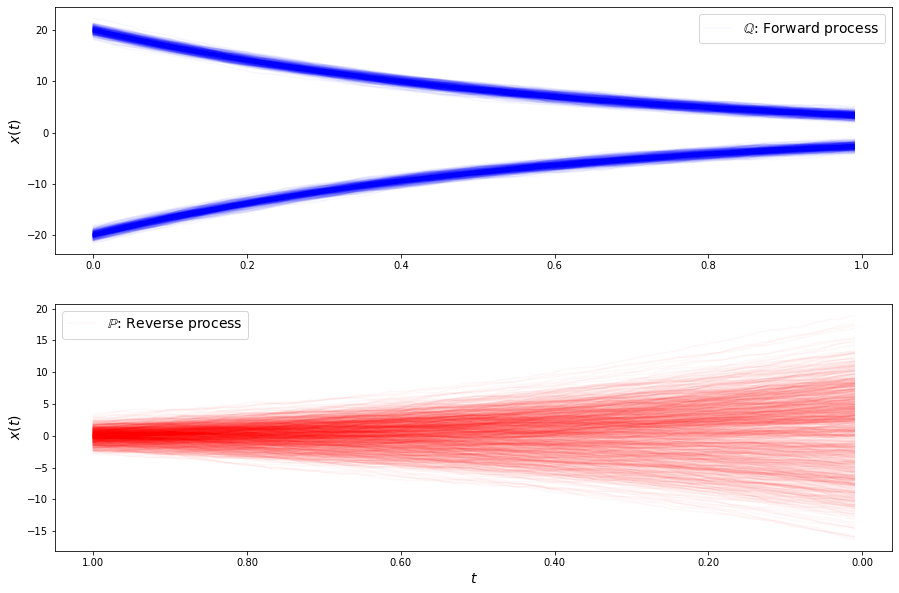

loss b 35.33820219601956
loss b 35.592508284110565
loss b 35.0083469339267
loss b 34.712463727012555
loss b 34.497774945031026
loss b 34.27499519294032
loss b 33.564497011788724
loss b 32.9193445345413
loss b 33.19794831211842
loss b 33.3391305055365
loss b 33.212927881516705
loss b 32.90164504530814
loss b 33.0124179051242
loss b 32.2596684319072
loss b 31.891075297691636
loss b 32.25699487922532
loss b 31.828183918241994
loss b 30.917472222370534
loss b 31.043398637029565
loss b 30.70297129336284
loss b 31.439541396120966
loss b 30.66741909962518
loss b 30.214179814442733
loss b 30.278842034231793
loss b 29.846869266150783
loss b 30.133190954658406
loss b 30.22596318950912
loss b 28.904667035023262
loss b 29.23920071965341
loss b 28.903893543645594
loss f 5.874021675040127
loss f 6.053368115971986
loss f 6.095112638856931
loss f 6.220132506788421
loss f 6.2833052445576865
loss f 6.387017478346506
loss f 6.586721790623843
loss f 6.672290585332136
loss f 6.836089176097725
loss f 7.0196

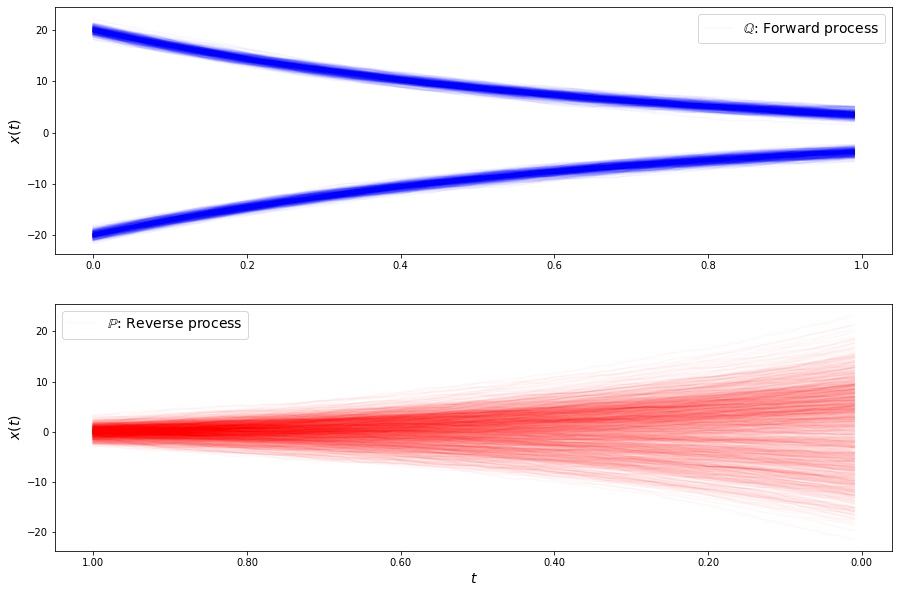

loss b 29.63233805360432
loss b 29.44943563800823
loss b 29.437821917835226
loss b 28.730104294035904
loss b 28.576572284454
loss b 28.172120200456142
loss b 28.39244520293647
loss b 27.723967456650595
loss b 26.797986414274668
loss b 26.945331659316057
loss b 27.300011340422145
loss b 26.780273192651396
loss b 27.515358634700437
loss b 27.20774477410972
loss b 27.050756963580994
loss b 27.033939667551973
loss b 26.82146360956073
loss b 26.713628521931412
loss b 26.608051339674752
loss b 25.97483908731337
loss b 25.53210567018883
loss b 25.715509277506655
loss b 26.134901488868103
loss b 26.11658994867769
loss b 25.602217123176548
loss b 25.06108369138232
loss b 25.667274210814437
loss b 25.299878952476472
loss b 25.462807317088934
loss b 25.219447032209796
loss f 15.901127630734363
loss f 16.062526124784263
loss f 16.229075789930093
loss f 16.12311634326894
loss f 16.288174716692296
loss f 16.15188822916042
loss f 16.521795366577162
loss f 16.303551443594376
loss f 16.137759667887163


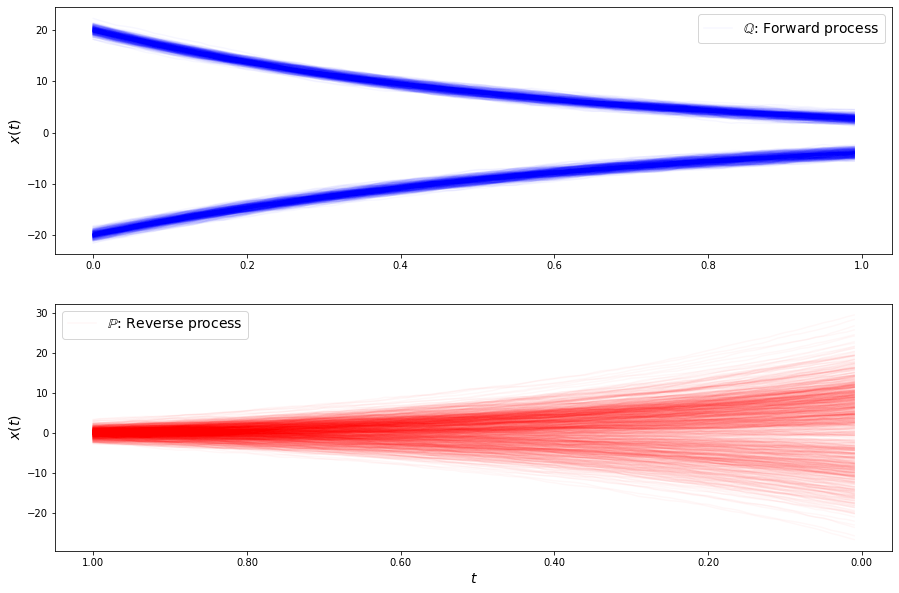

loss b 24.140621069636758
loss b 24.080046557869913
loss b 23.6867888122461
loss b 23.947032714667106
loss b 24.406763307128873
loss b 24.533631891535663
loss b 23.547822796498274
loss b 23.183942386999565
loss b 23.141308546136493
loss b 23.251172627684422
loss b 23.246737292220658
loss b 23.36790882945771
loss b 23.066733979127555
loss b 22.9867958523928
loss b 23.35677660138161
loss b 23.611054684550847
loss b 23.1187898484866
loss b 23.22616235649738
loss b 22.706553905217813
loss b 22.553723336114
loss b 22.607298866178102
loss b 22.8309408900978
loss b 22.44109792398095
loss b 22.969015412441216
loss b 23.13428105642888
loss b 22.102713606996396
loss b 22.4962569014643
loss b 22.972732917512438
loss b 22.263022014789208
loss b 22.039828051163948
loss f 17.638665681846778
loss f 17.104551312815556
loss f 16.672756346005034
loss f 16.633571065754907
loss f 16.455509676016934
loss f 15.858342017942366
loss f 15.51515557804404
loss f 15.125206772187473
loss f 15.265996864969402
loss 

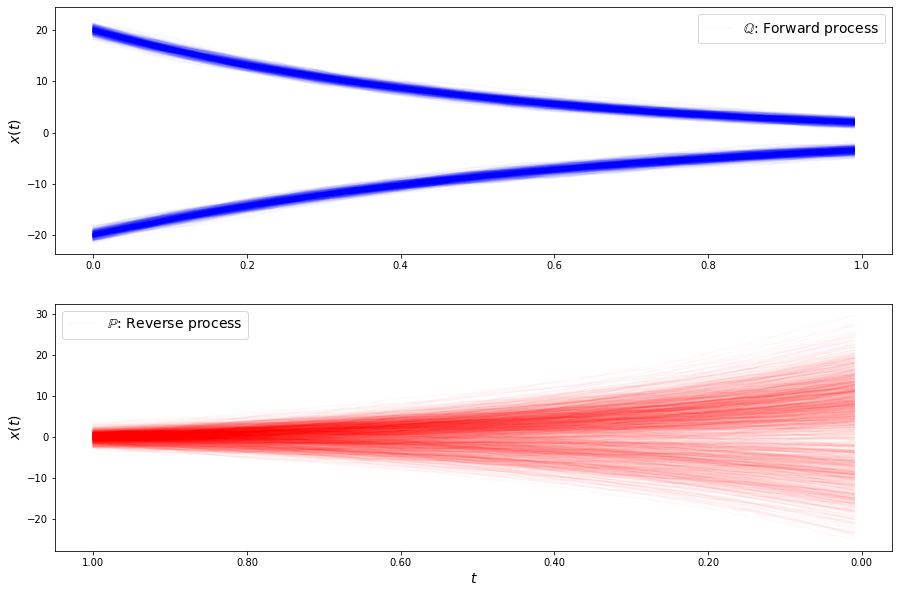

loss b 20.953541836681424
loss b 20.315856216282167
loss b 20.46727502290386
loss b 20.60808798078465
loss b 19.840425260517517
loss b 20.08142489869889
loss b 20.5186010171469
loss b 20.12576661832374
loss b 19.962204809992055
loss b 19.292714893848753
loss b 19.065115395114674
loss b 19.14124878533659
loss b 19.96478376528737
loss b 19.123390239388563
loss b 18.721528173267618
loss b 19.57962934273642
loss b 19.110024301995914
loss b 19.84610605892467
loss b 19.142191553022457
loss b 19.100566301605276
loss b 18.972176758778655
loss b 18.928450407729873
loss b 19.277823872719306
loss b 18.84766636037952
loss b 18.940789911057312
loss b 19.002553600704086
loss b 18.62029381560724
loss b 19.086079583992607
loss b 18.885945999318857
loss b 18.501679328429354
loss f 9.42470250103525
loss f 8.978127079406457
loss f 8.67434754989621
loss f 8.663740848330889
loss f 8.488786106480548
loss f 8.12239861128886
loss f 8.005777026949561
loss f 7.8107912286071395
loss f 7.784929561448759
loss f 7.

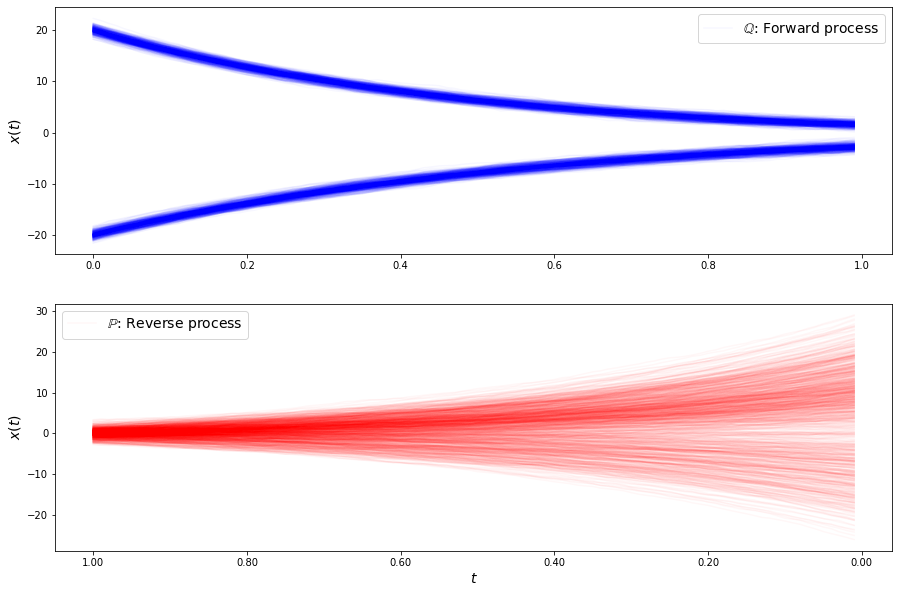

loss b 17.301600832985127
loss b 17.731657042778046
loss b 16.69268272538251
loss b 17.22127186745317
loss b 17.066735538124906
loss b 17.27762189921068
loss b 17.87850852838831
loss b 17.90153180268564
loss b 16.79900440461239
loss b 16.92281685778456
loss b 17.076533590765127
loss b 16.666917078983722
loss b 16.763406489327572
loss b 17.411708810495117
loss b 17.28568805743123
loss b 17.62379904058078
loss b 16.734531499253496
loss b 16.60354185305851
loss b 17.17325396397554
loss b 16.305240852768897
loss b 16.30969715699202
loss b 16.74206275553408
loss b 16.232320731305553
loss b 16.13906708419998
loss b 17.15867881228423
loss b 16.383751728437158
loss b 16.656500065671594
loss b 16.463586100704212
loss b 16.376294236184656
loss b 16.32504122538835
loss f 4.572315303474068
loss f 4.584989995627507
loss f 4.475570016845799
loss f 4.3369219800205006
loss f 4.338168016654633
loss f 4.240019973480387
loss f 4.102883791757985
loss f 4.164069770735353
loss f 4.024557177601653
loss f 4.0

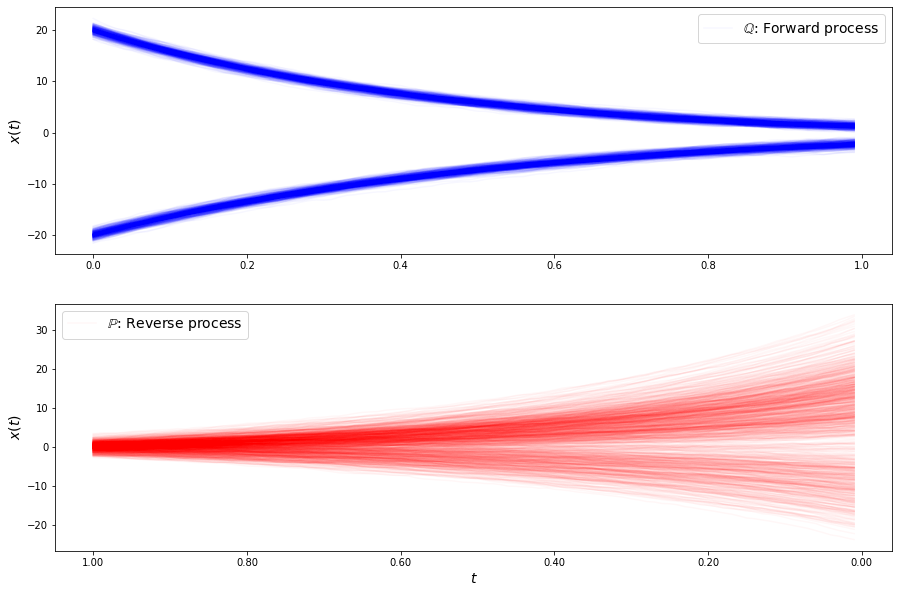

loss b 16.18689666513416
loss b 16.03025981801752
loss b 15.952376007493752
loss b 16.399858656910755
loss b 16.518092787418837
loss b 15.710647998243587
loss b 15.36498104690186
loss b 16.236341607928207
loss b 16.043647362901034
loss b 15.084539416627642
loss b 15.376835065416566
loss b 15.722776588467404
loss b 15.064905134816673
loss b 15.164555835113473
loss b 15.298976031787355
loss b 15.146535934056514
loss b 15.142070500964467
loss b 15.966752534284401
loss b 15.90149147978561
loss b 14.25030600528035
loss b 15.192836116595485
loss b 14.648822718058636
loss b 14.215258130458137
loss b 15.56196042224655
loss b 15.074887304181464
loss b 14.872442100486353
loss b 14.918863880367311
loss b 15.229199301148814
loss b 14.159651742698772
loss b 15.346424933649022
loss f 3.6957906221749335
loss f 3.624162644248021
loss f 3.644415607231016
loss f 3.6847405915645655
loss f 3.655885605123729
loss f 3.675883676516468
loss f 3.718081415725072
loss f 3.6904756412474784
loss f 3.68696341449446

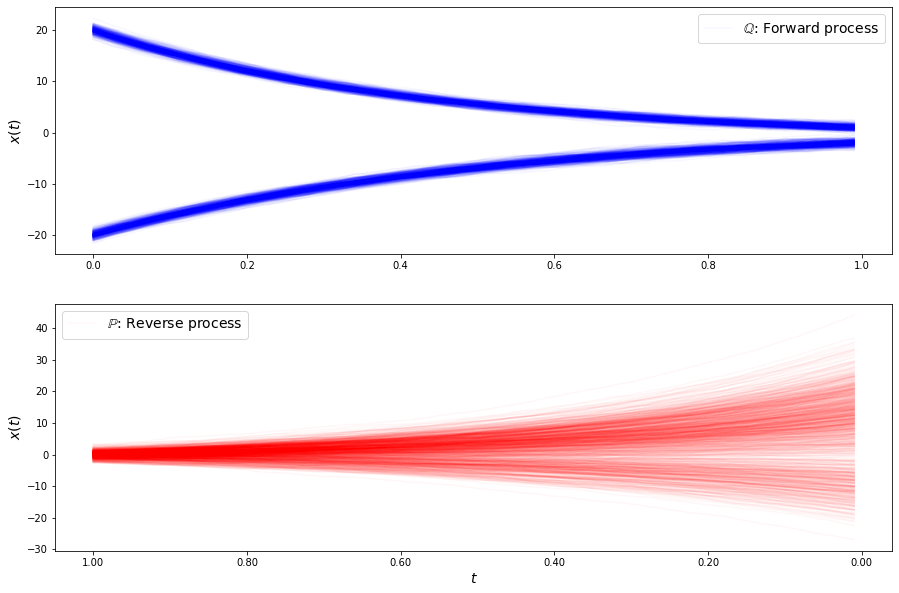

loss b 15.186969804855373
loss b 14.573205178507354
loss b 14.93344561432037
loss b 15.26120544691509
loss b 14.186754296013621
loss b 14.338430967086184
loss b 14.3856114871488
loss b 14.87427851246249
loss b 14.559805638870484
loss b 14.854670759113043
loss b 14.958868166012785
loss b 15.030529509910513
loss b 14.169166954307453
loss b 14.876854452505304
loss b 14.916548080536664
loss b 14.976356923751087
loss b 14.464876220996631
loss b 14.554972143299903
loss b 14.851493205003909
loss b 14.714756795430702
loss b 14.53509050924226
loss b 14.422362489587274
loss b 15.01231683234195
loss b 14.37441603603951
loss b 13.898734289394723
loss b 14.162640702130442
loss b 13.821225841904713
loss b 14.112077383539717
loss b 14.1523674769994
loss b 14.636598349261442
loss f 3.9590124588754847
loss f 4.0031950113298445
loss f 3.980788625417485
loss f 3.9896217723155414
loss f 4.0469247165492765
loss f 3.9941564677434425
loss f 4.086669158084019
loss f 4.10029444891705
loss f 4.138997145718441
l

In [ ]:


torch.autograd.set_detect_anomaly(True)
c.fit(200, 30, burn_iterations=2, plot=True)

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


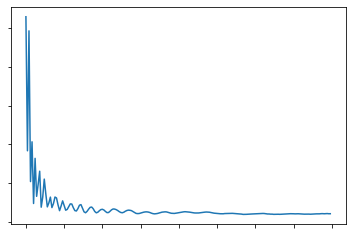

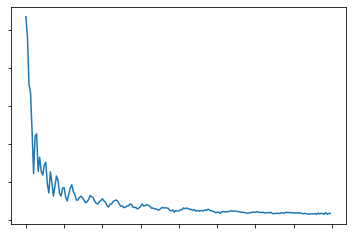

In [28]:
plt.plot(c.loss_f[2:])
plt.show()
plt.plot(c.loss_b[2:])

In [29]:
bb = lambda X: -c.b_backward(X)

t, Xts = c.sde_solver(
    c.b_forward.forward, c.sigma,
    c.X_0, c.dt,  c.number_time_steps, 0.0,
    c.theta_f, False, True
)
t_, Xts_ = c.sde_solver(
    bb, c.sigma, 
    c.X_1, c.dt, c.number_time_steps, 0.0, 
    c.theta_b, False, False
)

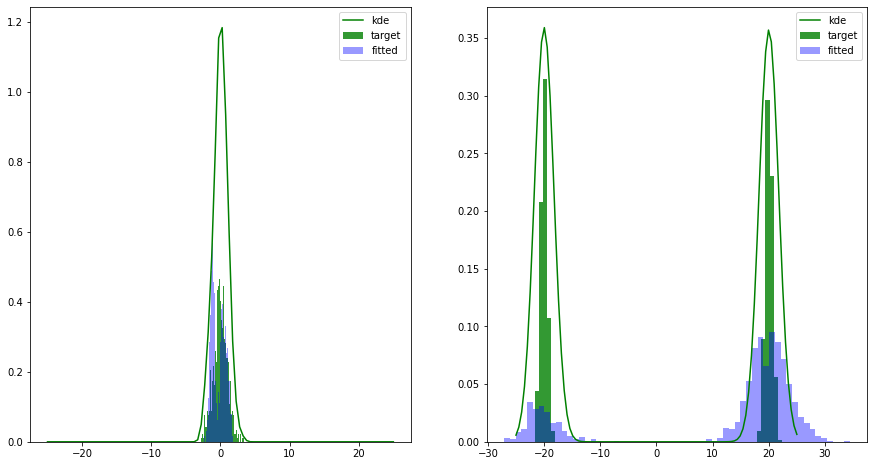

In [30]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
batch_terminal_empirical_f = next(c.data_stream(forward=True))
xx = torch.linspace(-25, 25).reshape(-1,1).cuda().double()

H = silvermans_rule(batch_terminal_empirical_f)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, H).detach().cpu().numpy())
axs[1].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[1].legend()




batch_terminal_empirical_b = next(c.data_stream(forward=False))
# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()

Hb = silvermans_rule(batch_terminal_empirical_b)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, Hb).detach().cpu().numpy())
axs[0].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()